# **Melanoma Detection Using Custom CNN**

### **Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


# **1. Data Understanding and Reading**

We start by defining paths for training and testing datasets and understanding the structure of the data.


### Importing all the important libraries

In [82]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [39]:
from glob import glob

In [40]:
from google.colab import drive
drive.mount('/content/gdrive')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [41]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/EPGP in ML and AI @ IIITB/20. DEEP LEARNING/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/EPGP in ML and AI @ IIITB/20. DEEP LEARNING/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [42]:
# Calculating the number of .jpg image files within Root directory and its subdirectories of Train and Test Datasets

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

# **2. Dataset Preparation**

Define some parameters for the loader:

In [43]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [44]:
train_ds = tf.keras.utils.image_dataset_from_directory(# tf.keras.utils.image_dataset_from_directory is a powerful function in TensorFlow/Keras
            data_dir_train, # to read images from the specified directory and its subdirectories
            batch_size=batch_size, #  to create batches of images and their corresponding labels
            image_size=(img_height, img_width), # to resize the images to the specified image_size
            seed=123, # to shuffle the data to ensure that the model is exposed to diverse samples during training
            validation_split=0.2, # to split the data into training and validation sets based on the validation_split parameter.
            subset='training',
            )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [45]:
val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='validation',
            )


Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [46]:
# Listing out all the classes of skin cancer and store them in a list.
# We can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# **3. Data Visualization**
Let's visualize one instance of all the nine classes present in the dataset.

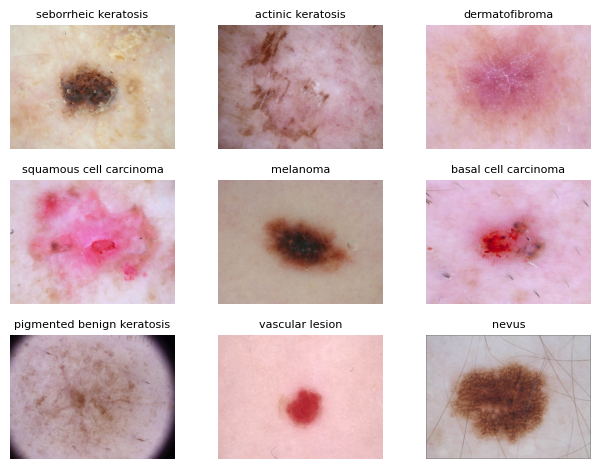

In [47]:
counter = 1
for c in data_dir_train.iterdir():
    # Make sure the directory is not empty and contains files
    files = list(c.iterdir())
    if files:  # Check if the list is not empty
        im = Image.open(files[0])  # Open the first image in the directory
        plt.subplot(3, 3, counter)
        plt.imshow(im)
        plt.title(str(c).split('/')[-1], fontsize=8)  # Set font size to avoid overlap
        counter += 1
        plt.axis("off")

# Adjust the layout to avoid title overlap
plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. This prefetches a certain number of batches of training data from the pipeline in advance and stores them in a buffer. This helps overlap data processing with model training, potentially improving training speed.

In [48]:
AUTOTUNE = tf.data.experimental.AUTOTUNE # Tells TensorFlow to analyze the hardware and dataset characteristics to choose the best settings for these data processing operations.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **4. Custom CNN Model Building**

We design a CNN model for accurate multi-class classification.

In [49]:
num_class = 9 # sets the number of output classes for the classification problem to 9
model = tf.keras.Sequential([  # This creates a sequential model in TensorFlow/Keras.
    layers.Rescaling(scale = 1./255, input_shape = (180,180,3)), # Normalizes pixel values
    layers.Conv2D(16,3,padding='same',activation= 'relu'),  # This is the first convolutional layer with 16 filters, kernel size 3x3, ReLU activation function
    layers.MaxPooling2D(pool_size = 2, strides = 2),  # These layers downsample the feature maps by selecting the maximum value within a 2x2 window.
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Flatten(),  # This layer converts the 2D feature maps from the previous convolutional layers into a 1D vector
    layers.Dense(128,activation='relu'), # This is the first fully connected (dense) layer. It has 128 neurons and uses the ReLU activation function.
    layers.Dense(num_class) # This is the output layer. It has 9 neurons, one for each class.
])

### **Compiling Model-1:-**
Choose an appropirate optimiser and loss function for model training

In [50]:
### Now we choose adam optimiser and loss function
### loss Function: Sparse Categorical Crossentropy Calculates the crossentropy loss between labels and predictions.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [51]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

### **Training Model-1:-**

In [52]:
# The fit method returns a History object containing information about the training process for each epoch.
# This object typically includes metrics like training loss, validation loss, training accuracy, and validation accuracy.
epochs = 20 # This line sets the number of training epochs to 20
history = model.fit( # This line initiates the training process using the fit method of the compiled model.
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 29s 115ms/step - loss: 1.9087 - accuracy: 0.2754 - val_loss: 1.6467 - val_accuracy: 0.4016
Epoch 2/20
169/169 [==============================] - 18s 104ms/step - loss: 1.4666 - accuracy: 0.4505 - val_loss: 1.4053 - val_accuracy: 0.4803
Epoch 3/20
169/169 [==============================] - 18s 105ms/step - loss: 1.2215 - accuracy: 0.5530 - val_loss: 1.1573 - val_accuracy: 0.5828
Epoch 4/20
169/169 [==============================] - 18s 106ms/step - loss: 1.0460 - accuracy: 0.6178 - val_loss: 1.1613 - val_accuracy: 0.6013
Epoch 5/20
169/169 [==============================] - 18s 106ms/step - loss: 0.8274 - accuracy: 0.6968 - val_loss: 1.0967 - val_accuracy: 0.6333
Epoch 6/20
169/169 [==============================] - 18s 107ms/step - loss: 0.6899 - accuracy: 0.7548 - val_loss: 0.9436 - val_accuracy: 0.6904
Epoch 7/20
169/169 [==============================] - 18s 107ms/step - loss: 0.5686 - accuracy: 0.7964 - val_loss: 0.9589 - val_ac

## **Visualizing the results after training Model-1:-**

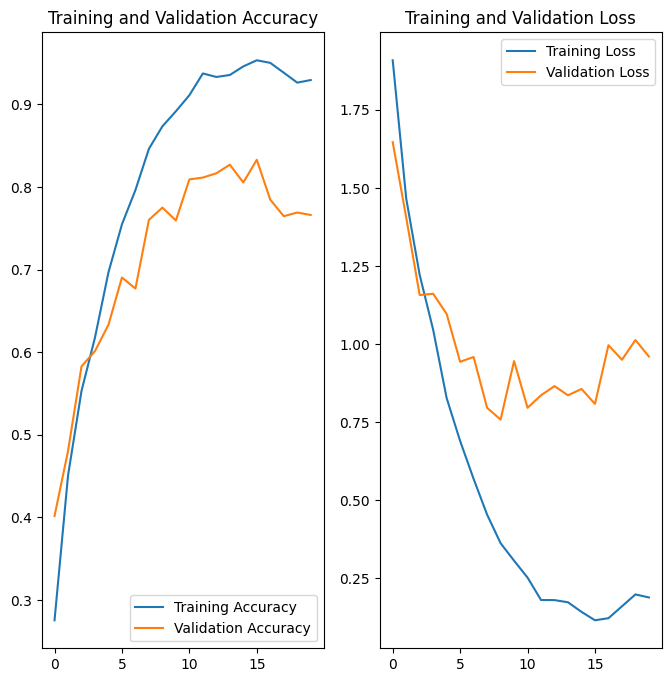

In [54]:
acc = history.history['accuracy'] # This line retrieves the training accuracy values from the history object returned by the model.fit method.
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs) # This creates a list representing the range of epochs (0 to epochs-1) for which the model was trained.

plt.figure(figsize=(8, 8)) # This line creates a new figure window with a size of 8x8 inches
plt.subplot(1, 2, 1) # This divides the figure window into a 1x2 grid of subplots. It creates the first subplot for plotting accuracy.
plt.plot(epochs_range, acc, label='Training Accuracy') # This plots the training accuracy values against the epoch range using a blue line and adds a label "Training Accuracy" to the plot.
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # This plots the validation accuracy values against the epoch range using an Orange line and adds a label "Validation Accuracy" to the plot.
plt.legend(loc='lower right') # This adds a legend to the first subplot, positioning it in the lower right corner.
plt.title('Training and Validation Accuracy') # This sets the title for the first subplot.

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **5. Findings and Data Augmentation**

## **Accuracy:**

**Training Accuracy:** The training accuracy steadily increases from the initial epochs, indicating that the model is learning from the training data.

**Validation Accuracy:** The validation accuracy increases initially but then plateaus and starts to decline after around Epoch 10. This suggests that the model is overfitting to the training data.

## **Loss:**

**Training Loss:**
The training loss decreases consistently throughout the training process, as expected.

**Validation Loss:** The validation loss decreases initially but then starts to increase significantly after around Epoch 10. This confirms the overfitting behavior observed in the accuracy plot.

**Recommendations for Improvement:**

**Early Stopping:** We Implement early stopping to avoid overfitting. This would halt training once the validation loss stops improving.

**Data Augmentation:** We use data augmentation to artificially increase the size of the training dataset. This improves generalization. We use more data augmentation to make the model more robust to different variations in input images.

**Example transformations:** rotation, flipping, zooming, and cropping.

In [55]:
# After we have analysed the model fit history for presence of underfit or overfit, we choose an appropriate data augumentation strategy.

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), # This helps the model learn to be invariant to the orientation of objects in the images.
  layers.experimental.preprocessing.RandomRotation(0.2), # This exposes the model to variations in object orientation and improves its robustness to rotations.
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2,0.3), width_factor=(0.2,0.3))
  # This augmentation helps the model learn to recognize objects at different scales and improves its robustness to variations in object size.
])

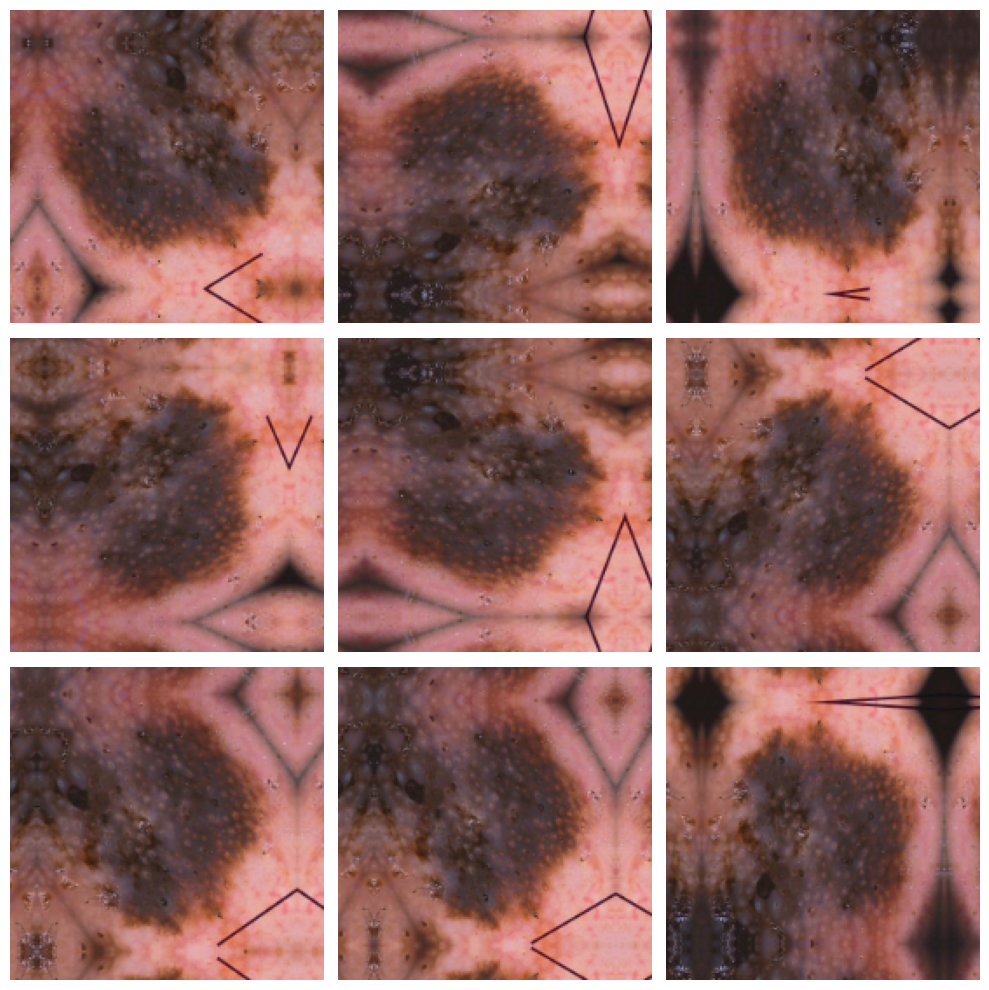

In [56]:
# Visualizing how your augmentation strategy works for one instance of training image.

for batch, labels in train_ds.take(1): # This loop iterates only once over the train_ds dataset using take(1)
    im = batch[0] # This extracts the first image from the current batch
    im = tf.reshape(im, (1, img_width, img_height, 3)) # This reshapes the image (im) into a format suitable for the model input.
    #The new shape is (1, img_width, img_height, 3)

plt.figure(figsize=(10, 10))
for i in range(9): # This loop iterates 9 times, applying the data augmentation to the original image (im) nine times.
    augmented_image = data_augmentation(im)[0] # This applies the data augmentation sequence (data_augmentation) to the image (im)
    # The [0] indexing extracts the augmented image from the output.
    img_to_show = augmented_image.numpy()  # This converts the augmented image from a TensorFlow tensor to a NumPy array for easier visualization.
    img_to_show = img_to_show.astype("uint8") # This converts the data type of the image array to unsigned 8-bit integers (uint8), which is a common format for image data.

    ax = plt.subplot(3, 3, i + 1) # This creates a subplot grid with 3 rows and 3 columns.
    # Inside the loop, i + 1 determines the position of each augmented image within the grid.
    plt.imshow(img_to_show) # This displays the current augmented image (img_to_show) within the corresponding subplot.
    plt.axis("off") # This hides the axis labels and ticks of the subplot for a cleaner visualization.

plt.tight_layout() # This adjusts the spacing between subplots to prevent overlapping.
plt.show() # This displays the final figure window containing the grid of 9 augmented images.


## **6. Creating Model-2 with Data Augmentation and Dropout to reduce Overfitting:-**


In [57]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## https://www.tensorflow.org/tutorials/images/data_augmentation
## https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip

num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

## **Compiling Model-2 to reduce Overfitting :-**

In [58]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

## **Training Model-2 to reduce Overfitting:-**

In [59]:
# Train our model-2 for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 21s 116ms/step - loss: 2.1483 - accuracy: 0.1741 - val_loss: 2.0903 - val_accuracy: 0.2146
Epoch 2/20
169/169 [==============================] - 19s 115ms/step - loss: 1.7824 - accuracy: 0.3049 - val_loss: 1.7446 - val_accuracy: 0.3705
Epoch 3/20
169/169 [==============================] - 20s 116ms/step - loss: 1.5538 - accuracy: 0.4097 - val_loss: 1.4175 - val_accuracy: 0.4254
Epoch 4/20
169/169 [==============================] - 20s 116ms/step - loss: 1.4522 - accuracy: 0.4451 - val_loss: 1.4273 - val_accuracy: 0.4640
Epoch 5/20
169/169 [==============================] - 20s 116ms/step - loss: 1.4162 - accuracy: 0.4509 - val_loss: 1.4780 - val_accuracy: 0.4180
Epoch 6/20
169/169 [==============================] - 20s 116ms/step - loss: 1.3443 - accuracy: 0.4811 - val_loss: 1.4087 - val_accuracy: 0.4543
Epoch 7/20
169/169 [==============================] - 20s 116ms/step - loss: 1.3466 - accuracy: 0.4683 - val_loss: 1.2446 - val_ac

## **Visualizing the results of  Training Model-2:-**

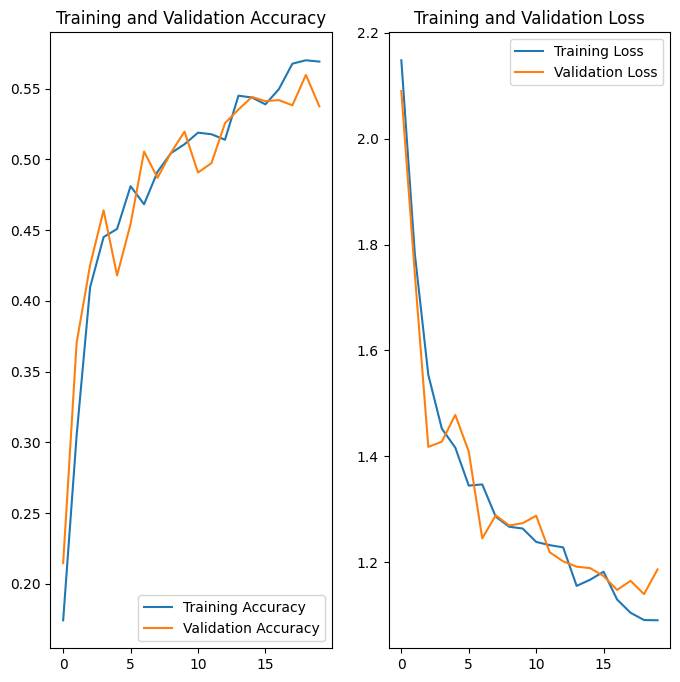

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **7. Findings after Model-2 Training:-**

We'll see if there is any evidence of model overfit or underfit and if there is some improvement now as compared to the previous model run.

In the above model use of data augmentation and dropout layer reduced the problem of overfitting.

The accuracy of the model has greatly increased along with the synchronization of the validation accuracy. The loss function is synchronously exhausted for the training and validation data.

Overall, the model might be exhibiting some signs of overfitting, although not as pronounced as in the previous example.

## **8. Finding the distribution of classes in the training dataset:-**
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [61]:
## original_df - > path_list, lesion_list
path_list=[] # This line creates an empty list named path_list to store the paths to different images or files within our dataset.
lesion_list=[] # This line creates another empty list named lesion_list to store corresponding labels or classifications for the images or files whose paths are stored in path_list.

In [62]:
for i in class_names: # This outer loop iterates through a list called class_names, which contains the names of different classes or categories of images
  for j in data_dir_train.glob(i+'/*.jpg'): # This inner loop iterates through all .jpg image files within a subdirectory of data_dir_train named after the current class (i).
    # For example, if i is "melanoma", it would iterate through files like data_dir_train/melanoma/melanoma_1.jpg, data_dir_train/melanoma/melanoma_2.jpg, etc.
    path_list.append(str(j)) # This line appends the full path of each found image file (j) to the path_list
    lesion_list.append(i) # This line appends the corresponding class name (i) to the lesion_list for each image.
dataframe_dict_original = dict(zip(path_list, lesion_list)) # This line creates a dictionary (dataframe_dict_original) where:
#The keys are the image paths stored in path_list. The values are the corresponding class labels stored in lesion_list.
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label']) # This converts the dictionary into a list of tuples
# Using the list of tuples, a Pandas DataFrame with two columns: 'Path' for the image paths and 'Label' for the corresponding class labels is created
# and the created DataFrame is assigned to the variable original_df.
original_df

,Path,Label
0,/content/gdrive/MyDrive/EPGP in ML and AI @ II...,actinic keratosis
1,/content/gdrive/MyDrive/EPGP in ML and AI @ II...,actinic keratosis
2,/content/gdrive/MyDrive/EPGP in ML and AI @ II...,actinic keratosis
3,/content/gdrive/MyDrive/EPGP in ML and AI @ II...,actinic keratosis
4,/content/gdrive/MyDrive/EPGP in ML and AI @ II...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/EPGP in ML and AI @ II...,vascular lesion
2235,/content/gdrive/MyDrive/EPGP in ML and AI @ II...,vascular lesion
2236,/content/gdrive/MyDrive/EPGP in ML and AI @ II...,vascular lesion
2237,/content/gdrive/MyDrive/EPGP in ML and AI @ II...,vascular lesion


### **Visualizing Class Distribution:-**

<ipython-input-64-0a31a47d096a>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [plt.cm.get_cmap('tab20', len(class_names))(i) for i in range(len(class_names))]


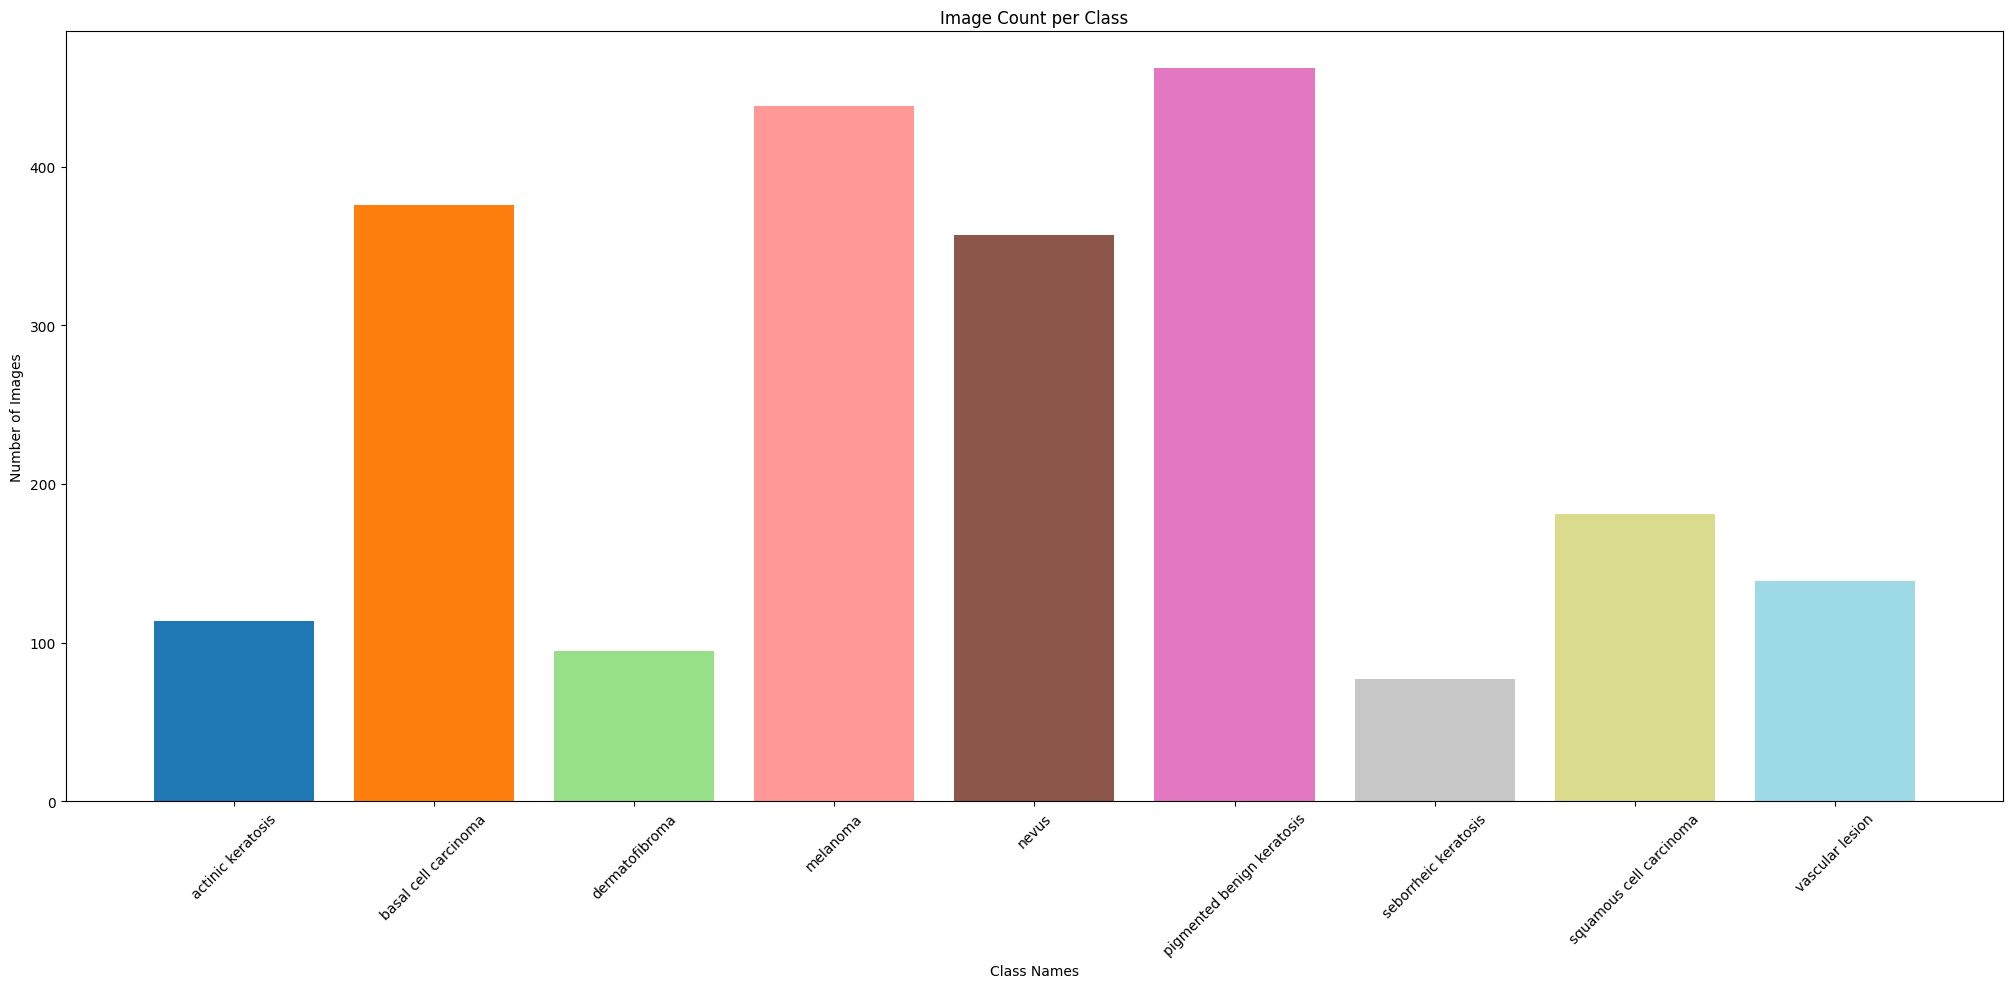

In [64]:
class_count = []  # This line creates an empty list named class_count to store the number of images for each class.

# Generate a list of random colors for each class
colors = [plt.cm.get_cmap('tab20', len(class_names))(i) for i in range(len(class_names))]

for i in class_names:  # This loop iterates over the list class_names
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))  # This line calculates the number of images belonging to the current class (i).

plt.figure(figsize=(25, 10))

# This line creates a bar chart to visualize the class distribution.
plt.bar(class_names, class_count, color=colors)

plt.xlabel('Class Names')  # Label for x-axis
plt.ylabel('Number of Images')  # Label for y-axis
plt.title('Image Count per Class')  # Title of the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility if needed
plt.show()


## **9. Findings from Visualizing Class Distribution:-**

#### - Which class has the least number of samples?
The least number of samples are in seborrheic keratosis

#### - Which classes dominate the data in terms proportionate number of samples?
The classes dominate in the data are:-
* pigmented benign Keratosis
* melanoma
* basal cell carcinoma
* nevus


## **10. Rectifying the Class Imbalance using Augmentor Package**

#### **Context:** We can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [65]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. We instantiate a `Pipeline` object pointing to a directory containing our initial image data set.
2. We define a number of operations to perform on this data set using our `Pipeline` object.
3. We execute these operations by calling the `Pipeline’s` `sample()` method.


In [66]:
path_to_training_dataset = "/content/gdrive/MyDrive/EPGP in ML and AI @ IIITB/20. DEEP LEARNING/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
import Augmentor
for i in class_names: # This loop iterates through a list called class_names
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset, i)) # This line creates an Augmentor.Pipeline object for each class.
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10) # This adds a rotation operation to the pipeline.
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/EPGP in ML and AI @ IIITB/20. DEEP LEARNING/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D117C2AE770>: 100%|██████████| 500/500 [00:03<00:00, 132.85 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/EPGP in ML and AI @ IIITB/20. DEEP LEARNING/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D10F87B0760>: 100%|██████████| 500/500 [00:03<00:00, 128.28 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/EPGP in ML and AI @ IIITB/20. DEEP LEARNING/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D10F80407C0>: 100%|██████████| 500/500 [00:04<00:00, 114.92 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/EPGP in ML and AI @ IIITB/20. DEEP LEARNING/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D10D9B61FF0>: 100%|██████████| 500/500 [00:05<00:00, 87.93 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/EPGP in ML and AI @ IIITB/20. DEEP LEARNING/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2530x2122 at 0x7D111C5134F0>: 100%|██████████| 500/500 [00:05<00:00, 89.88 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/EPGP in ML and AI @ IIITB/20. DEEP LEARNING/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D111C512830>: 100%|██████████| 500/500 [00:05<00:00, 98.63 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/EPGP in ML and AI @ IIITB/20. DEEP LEARNING/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D15B5479DB0>: 100%|██████████| 500/500 [00:04<00:00, 115.98 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/EPGP in ML and AI @ IIITB/20. DEEP LEARNING/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D117C12EAA0>: 100%|██████████| 500/500 [00:03<00:00, 126.05 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/EPGP in ML and AI @ IIITB/20. DEEP LEARNING/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D117C12D870>: 100%|██████████| 500/500 [00:04<00:00, 123.50 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [67]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [68]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/EPGP in ML and AI @ IIITB/20. DEEP LEARNING/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011151.jpg_35e852bb-7391-4c4c-8a14-3f62169a0170.jpg',
 '/content/gdrive/MyDrive/EPGP in ML and AI @ IIITB/20. DEEP LEARNING/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010971.jpg_6ad747ab-1e96-4595-bc81-7186ac9d69e8.jpg',
 '/content/gdrive/MyDrive/EPGP in ML and AI @ IIITB/20. DEEP LEARNING/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011031.jpg_86fa0124-9be2-46c1-a435-a4b3cead6490.jpg',
 '/content/gdrive/MyDrive/EPGP in ML and AI @ IIITB/20. DEEP LEARNING/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratos

In [69]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [70]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [71]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [72]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,1462
melanoma,1438
basal cell carcinoma,1376
nevus,1357
squamous cell carcinoma,1181
vascular lesion,1139
actinic keratosis,1114
dermatofibroma,1095
seborrheic keratosis,1077


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## **11. Training Model-3 on the data created using Augmentor:-**

In [73]:
batch_size = 32
img_height = 180
img_width = 180

## **Creating a training dataset for Model-3:-**

In [74]:
data_dir_train="/content/gdrive/MyDrive/EPGP in ML and AI @ IIITB/20. DEEP LEARNING/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'training',
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


## **Creating a validation dataset for Model-3:-**

In [75]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'validation',
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


## **Creating Model-3 that rectifies Class Imbalance:-**

In [76]:
## your code goes here
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

## **Compiling Model-3 that rectifies Class Imbalance:-**

In [77]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## **Training Model-3 that rectifies Class Imbalance:-**

In [78]:
epochs = 30
## Your code goes here, use 50 epochs.
history30 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)# your model fit code

Epoch 1/30
281/281 [==============================] - 38s 130ms/step - loss: 1.7399 - accuracy: 0.3304 - val_loss: 1.5118 - val_accuracy: 0.3885
Epoch 2/30
281/281 [==============================] - 37s 130ms/step - loss: 1.4335 - accuracy: 0.4342 - val_loss: 1.3598 - val_accuracy: 0.4619
Epoch 3/30
281/281 [==============================] - 37s 130ms/step - loss: 1.3622 - accuracy: 0.4645 - val_loss: 1.4317 - val_accuracy: 0.4566
Epoch 4/30
281/281 [==============================] - 37s 132ms/step - loss: 1.2837 - accuracy: 0.4885 - val_loss: 1.3524 - val_accuracy: 0.4838
Epoch 5/30
281/281 [==============================] - 37s 131ms/step - loss: 1.2577 - accuracy: 0.5018 - val_loss: 1.2322 - val_accuracy: 0.5287
Epoch 6/30
281/281 [==============================] - 37s 130ms/step - loss: 1.2062 - accuracy: 0.5205 - val_loss: 1.2310 - val_accuracy: 0.5291
Epoch 7/30
281/281 [==============================] - 37s 130ms/step - loss: 1.1990 - accuracy: 0.5257 - val_loss: 1.4119 - val_ac

## **Visualizing Model-3 results after Training:-**

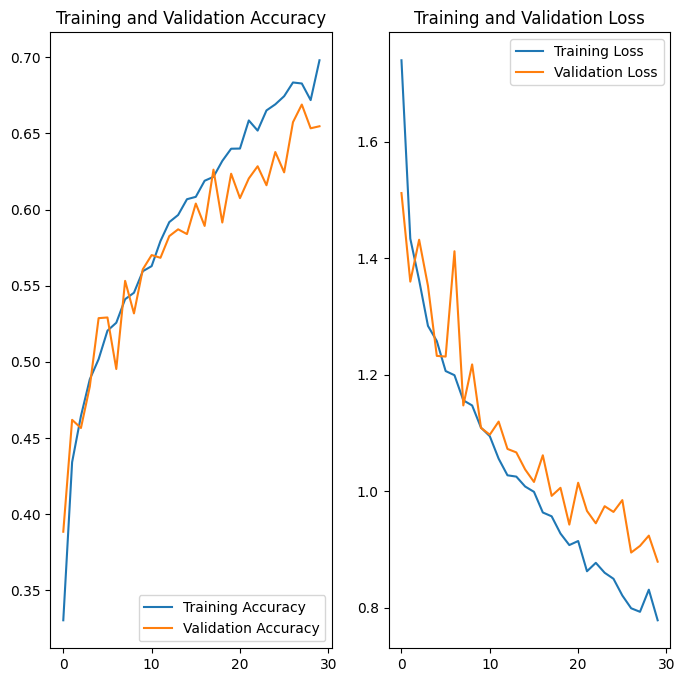

In [79]:
acc = history30.history['accuracy']
val_acc = history30.history['val_accuracy']

loss = history30.history['loss']
val_loss = history30.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **12. Analyzing Results:-**

The problem of overfitting and underfitting was solved and the model was well trained for predictions. Data augmentation and class equalization were found to be useful in improving model performance in this case.
